In [1]:
!pip install musthe

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from musthe import *

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import wave
import struct
import sys
#from scikits.audiolab import *
import random
from datetime import datetime
import operator
import scipy
from scipy import signal
import math
from pylab import*
import cmath
import operator
from tempfile import TemporaryFile


def read_audio(filename):
	spf = wave.open(filename,'r')
	signal = spf.readframes(-1)
	signal = np.fromstring(signal, 'Int16')
	p = spf.getnchannels()
	f = spf.getframerate()
	sound_info = np.zeros(len(signal),dtype=float)
	signal = signal.astype(np.float)
	sound_info = signal/max(signal)

	#sound_info = sound_info[1:len(sound_info):2]
	if p==2:
		sound_info = scipy.signal.decimate(sound_info,2)

	return p ,f , sound_info


def spectrogram(sound_info,f,nfft,hop):
	Pxx, freqs, bins, im = specgram(sound_info, Fs = f, NFFT = nfft, noverlap=nfft-hop, scale_by_freq=True,sides='default')
	return Pxx, freqs, bins, im


def hz_to_oct(freq):
	#A6 = 27.5*(2^6)
	#A0 = 27.5
	#A4 = 440
	fmin = 27.5
	b = 24
	return np.log2(freq/fmin)*b


def oct_to_hz(oct):
	fmin = 27.5
	b = 24.0
	return fmin*(2**(oct/b))


def generate_filterbank(NFFT,fs,b,z):
	#b is bins per octave
	#z is number of octaves
	#b = 24
	#z = 6
	#fs(downsampled) = 44100/4 = 11025

	octmax = b*z

	octpts = np.arange(-1,octmax+1)
	#print 'octpts',octpts
	#print len(octpts)

	ctrfrq = oct_to_hz(octpts)
	#print("ctrfrq", ctrfrq)
	#print len(ctrfrq)
	tmp =(NFFT+2)
	print(fs)
	tmp = tmp * ctrfrq/(fs/2)
	ctrrep = np.floor(tmp)
	#print "ctrrep",ctrrep
	#print len(ctrrep)

	bank = np.zeros([len(octpts)-2, int(NFFT/2)+1],dtype=float)

	for j in xrange(0,len(octpts)-2):
		y = np.hamming(ctrrep[j+2]-ctrrep[j])
		area = trapz(y, dx=5)
		if area==0:
			area=1
		y2 = (y/area)
		bank[j,ctrrep[j]:ctrrep[j+2]] = y2
		#plot(bank[j,:])

	#show()
	return bank


def generate_template():
	b = np.zeros(288).reshape(12,24)

	a = [0,0,0,1,0,0,0,1,0,0,1,0]
	b[:,0] = a

	for i in range(1,12):
		b[:,i] = np.roll(b[:,i-1],1)

	minor = [0,0,0,1,0,0,1,0,0,0,1,0]
	b[:,12] = minor

	for i in range(13,24):
		b[:,i] = np.roll(b[:,i-1],1)
	
	return b

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:3445: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.ar

frequency is  44100
channels are  1
148475
37119
length of audio is  37119


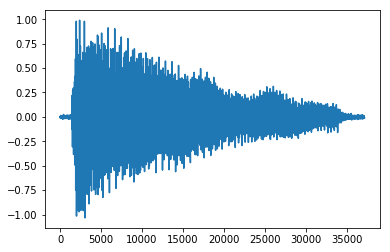

In [6]:
"""
Read input audio wav file
"""
p, f, sound_info_old = read_audio('samples/am0.wav')
print("frequency is " ,f)
print("channels are ",p)
print(len(sound_info_old))
#30 seconds is 1323000
sound_info_deci = scipy.signal.decimate(sound_info_old,4)
print(len(sound_info_deci))
#165375 is 15 sec 330750 is 30 sec for downsampled signal
sound_info = sound_info_deci[0:165375]
print("length of audio is ",len(sound_info))
f = f/4

plot(sound_info)
show()

<function RandomState.f>

shape of Spectrogram is  (3001, 244)


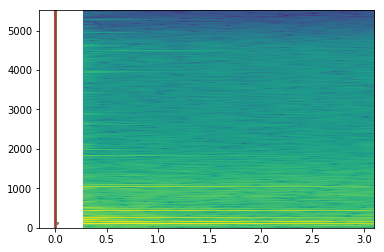

In [8]:
"""
Compute spectrogram
"""

Pxx, freqs, bins, im = spectrogram(sound_info, f, 6000, 128)
print("shape of Spectrogram is ",shape(Pxx))
plot(Pxx,freqs)
show()


In [18]:
"""
Generate CQ filterabank
"""

bank = generate_filterbank(NFFT=6000,fs=f,b=24,z=6)
print("shape of bank",shape(bank))
im = imshow(bank,aspect='auto',interpolation='nearest',origin='lower')
show()

<built-in method f of mtrand.RandomState object at 0x11a36bea0>


TypeError: unsupported operand type(s) for /: 'builtin_function_or_method' and 'int'

In [4]:

"""
Compute spectrogram
"""

Pxx, freqs, bins, im = spectrogram(sound_info, f, 6000, 128)
print "shape of Spectrogram is",shape(Pxx)
#plot(Pxx,freqs)
#show()


"""
Generate CQ filterabank
"""

bank = generate_filterbank(NFFT=6000,fs=f,b=24,z=6)
print "shape of bank",shape(bank)
#im = imshow(bank,aspect='auto',interpolation='nearest',origin='lower')
#show()


"""
Generate CQ spectrogram as the dot product of spectrogram and CQ filterabank
"""

sal = np.dot(bank,Pxx)
b,col = shape(sal)

#Replace 0 by 1 in matrix before taking log
for i in range(0,len(sal)):
	for j in range(0,len(sal[0])):
		if sal[i][j] == 0:
			sal[i][j]+=1

sal = 10*np.log10(sal)
#Normalize
salm = np.zeros(shape(sal))
salm = (sal - sal.min())/(sal.max()-sal.min())
#salm = sal

"""
for i in range(col):
	salm[:,i] = sal[:,i]/sum(sal[:,i])
"""

print "shape of CQ Spectrogram is",shape(salm)
subplot(3,1,2)
title('CQ spectrogram (dB)')
#xlim(0,(len(sound_info)/11025.00))
im = imshow(salm,aspect='auto',interpolation='nearest',origin='lower')
xticks(np.arange(0,col,172),[0,2,4,6,8,10,12,14])

#show()


"""
Generate Chroma
"""
row,col = shape(salm)
#print row
#print col
b = 24

chrm = np.zeros(b*col).reshape(b,col)

for i in range(col):
	c = salm[:,i]
	for j in range(b):
		chrm[j,i] = sum(c[j:row:b])

#print chrm

chrm_new = np.zeros(b*col).reshape(b,col)

#median
"""
for i in range(b):
	for j in range(col):
		chrm_new[i,j] = np.median(chrm[i,j-3:j+3])
"""

chrm_new = chrm

chrm_new_norm = np.zeros(b*col).reshape(b,col)

#normalise
for i in range(col):
	chrm_new_norm[:,i] = chrm_new[:,i]/sum(chrm_new[:,i])
	#chrm_new_norm[i,j] = np.median(chrm_new[i,j-10:j+10])
#print chrm_new_norm


print "shape of Chroma is",shape(chrm_new_norm)
subplot(3,1,3)
title('Chroma (dB)')

#save chroma in a .npy file
chromaa = TemporaryFile()
np.save('chroma1.npy',chrm_new_norm)

im2 = imshow(chrm_new_norm,aspect='auto',interpolation='nearest',origin='lower')
#xlim(0,(len(sound_info)/11025.00))
yticks([1,3,5,7,9,11,13,15,17,19,21,23], ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#'])
xticks(np.arange(0,col,172),[0,2,4,6,8,10,12,14])

#show()

#only for plotting
subplot(3,1,1)
title('Spectrogram (dB)')
Pxx, freqs, bins, im = spectrogram(sound_info, f, 6000, 128)
plot(Pxx,freqs)
xlim(0,(np.ceil(len(sound_info)/11025)))
show()


"""
Generate Template
"""

temp = generate_template()
xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23], 
	['C','C#','D','D#','E','F','F#','G','G#','A','A#','B','c','c#','d','d#','e','f','f#','g','g#','a','a#','b'])
yticks([0,1,2,3,4,5,6,7,8,9,10,11,12], ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#'])
title('Template')
im = imshow(temp,aspect='auto',interpolation='nearest',origin='lower')
show()

print "template shape is",shape(temp)


"""
Fitness matrix computation by taking
dot product of Template and Chroma
"""

#Since b=24, we need to take mean of 2 rows
lol = zip(*chrm_new_norm[::-1])

print shape(lol)
lol = np.asarray(lol)
grand = lol.reshape(-1,2).mean(axis=1).reshape(lol.shape[0],-1)
#print shape(grand)

grand2 = zip(*grand)[::-1]
#print shape(grand2)

match = np.dot(temp.T,grand2)

match_norm = np.zeros(shape(match))

#normalize

for i in range(col):
	match_norm[:,i] = match[:,i]/sum(match[:,i])

print "matched array is",shape(match_norm)
title('Fitness Matrix')
im = imshow(match_norm,aspect='auto',interpolation='nearest',origin='lower')
yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23], 
	['C','C#','D','D#','E','F','F#','G','G#','A','A#','B','c','c#','d','d#','e','f','f#','g','g#','a','a#','b'])
show()

#save tempogram in a .npy file
match22 = TemporaryFile()
np.save('tempogram1.npy',match_norm)

print 'end'

SyntaxError: invalid syntax (<ipython-input-4-090da909f23b>, line 10)

In [ ]:
fro

In [10]:
import scikits

In [14]:
from scikits.crab import datasets

SyntaxError: invalid syntax (book_crossing.py, line 119)

In [3]:
!pip install scikits.audiolab

  Using cached https://files.pythonhosted.org/packages/b0/d8/d9babf3e4fa3ac8094e1783415bf60015a696779f4da4c70ae6141aa5e3a/scikits.audiolab-0.11.0.tar.gz
    Complete output from command python setup.py egg_info:
    SndfileInfo:
    customize UnixCCompiler
      libraries sndfile not found in /anaconda3/lib
    customize UnixCCompiler
      libraries sndfile not found in /usr/local/lib
    customize UnixCCompiler
      libraries sndfile not found in /usr/lib
    customize UnixCCompiler
      libraries sndfile not found in /opt/local/lib
    Traceback (most recent call last):
      File "scikits/audiolab/pysndfile/setup.py", line 20, in configuration
        sf_config = sf_info.get_info(2)
      File "/anaconda3/lib/python3.6/site-packages/numpy/distutils/system_info.py", line 631, in get_info
        raise self.notfounderror(self.notfounderror.__doc__)
    numpy.distutils.system_info.NotFoundError: Some third-party program or library is not found.
    
    During handling of the above 

In [2]:
!pip install --upgrade pip

    100% |████████████████████████████████| 1.4MB 517kB/s ta 0:00:01
  Found existing installation: pip 18.1
    Uninstalling pip-18.1:
      Successfully uninstalled pip-18.1


In [4]:
!git clone https://github.com/muricoca/crab.git

Cloning into 'crab'...
remote: Enumerating objects: 1515, done.
remote: Total 1515 (delta 0), reused 0 (delta 0), pack-reused 1515
Receiving objects: 100% (1515/1515), 2.91 MiB | 469.00 KiB/s, done.
Resolving deltas: 100% (701/701), done.


In [6]:
!cd crab

In [8]:
!cd crab & python setup.py install

python: can't open file 'setup.py': [Errno 2] No such file or directory
